## Ring-hydroxylating Dioxygenases

In [209]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.ensemble import RandomForestRegressor
import re
from prince import MCA
import matplotlib.cm as cm
from Bio.SeqUtils import seq3

# Download necessary resources from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /Users/lucas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lucas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
file = 'alignment.fasta'
original = list(SeqIO.parse(file, "fasta"))
original

[SeqRecord(seq=Seq('------------------------------------------------------...---'), id='A0A1V1ZE67_9FLAO/178-361', name='A0A1V1ZE67_9FLAO/178-361', description='A0A1V1ZE67_9FLAO/178-361', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='A0A0J1DCU0_9BURK/170-416', name='A0A0J1DCU0_9BURK/170-416', description='A0A0J1DCU0_9BURK/170-416', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='J2WKD9_9SPHN/182-387', name='J2WKD9_9SPHN/182-387', description='J2WKD9_9SPHN/182-387', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='A0A1Q3AVG0_CEPFO/233-414', name='A0A1Q3AVG0_CEPFO/233-414', description='A0A1Q3AVG0_CEPFO/233-414', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='A0A5N0VGT3_9PSEU/179-385', name='A0A5N0VGT3_9PSEU/179-385', description='A0A5N0VGT3_9PSEU/179-385', dbxrefs=[]),
 SeqRec

In [3]:
# metadata, raw_data =
headers, sequences = [], []
for row in original:
    headers.append(row.id)
    sequences.append(row.seq)
data = np.array(sequences)
data

array([['-', '-', '-', ..., '-', '-', '-'],
       ['-', '-', '-', ..., '-', '-', '-'],
       ['-', '-', '-', ..., '-', '-', '-'],
       ...,
       ['-', '-', '-', ..., '-', '-', '-'],
       ['-', '-', '-', ..., '-', '-', '-'],
       ['-', '-', '-', ..., '-', '-', '-']], dtype='<U1')

In [4]:
# Define the set of values to replace
values_to_replace = ['-', *[chr(i) for i in range(ord('a'), ord('z')+1)]]
df = pd.DataFrame(data).replace(values_to_replace, np.nan)
df

,0,1,2,3,4,5,6,7,8,9,...,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Calculate the average, minimum, and maximum number of NaN cells in each row
nan_stats = df.apply(lambda row: row.isna().mean(), axis=1)

avg_nan = nan_stats.mean()
min_nan = nan_stats.min()
max_nan = nan_stats.max()

# Display the results
print("Average NaN cells per row:", avg_nan)
print("Minimum NaN cells per row:", min_nan)
print("Maximum NaN cells per row:", max_nan)

Average NaN cells per row: 0.8631679752169495
Minimum NaN cells per row: 0.8261224489795919
Maximum NaN cells per row: 0.9779591836734693


In [6]:
# Set the threshold for non-null values
threshold = .85
min_rows = int(threshold * df.shape[0])

# Remove columns with NaN values above the threshold
df_clean = df.dropna(thresh=min_rows, axis=1)
min_cols = int(threshold * df_clean.shape[1])

print(min_rows, min_cols)

# Remove rows with NaN values above the threshold
df_clean = df_clean.dropna(thresh=min_cols, axis=0)

df_clean

7973 89


,150,177,178,179,180,181,182,185,186,187,...,996,997,1001,1005,1006,1007,1013,1014,1015,1053
0,H,V,N,C,H,W,A,L,Y,C,...,E,L,V,N,K,G,V,Q,S,R
1,R,I,K,G,D,W,K,L,Y,M,...,E,Y,S,C,A,G,I,Q,A,R
2,D,I,D,A,N,W,K,L,T,Y,...,E,A,G,Q,R,G,L,N,S,G
3,T,L,E,C,N,W,K,V,F,C,...,E,G,V,Q,R,G,L,E,S,P
4,E,I,E,A,N,W,K,V,V,N,...,E,N,V,Q,R,G,M,N,T,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9373,E,C,N,Y,N,W,K,T,F,I,...,E,R,M,D,A,G,R,R,A,R
9376,NaN,I,H,C,N,W,K,M,Y,L,...,E,S,M,Q,R,G,L,A,A,R
9377,V,E,K,G,N,W,K,L,T,M,...,E,F,S,Q,R,G,A,A,S,S
9378,E,I,T,A,N,W,K,L,V,V,...,E,R,M,Q,R,G,R,S,S,P


In [7]:
# Create a mask where null values are True and non-null values are False
mask = df_clean.isna()

mask

,150,177,178,179,180,181,182,185,186,187,...,996,997,1001,1005,1006,1007,1013,1014,1015,1053
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9373,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9376,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9377,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9378,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
# Convert the mask to integers (0 for True/null, 1 for False/non-null)
mask_int = mask.astype(int)

mask_int

,150,177,178,179,180,181,182,185,186,187,...,996,997,1001,1005,1006,1007,1013,1014,1015,1053
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9376,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


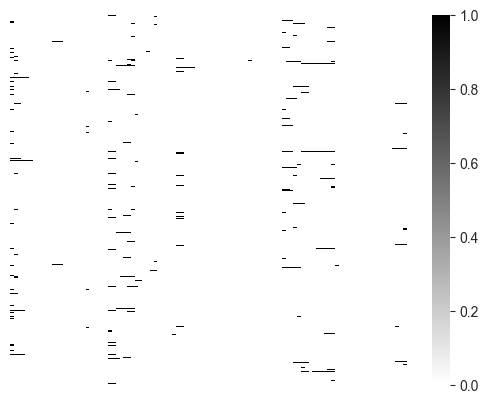

In [9]:
# Plot the heatmap
sns.heatmap(mask_int, cmap='binary', xticklabels=False, yticklabels=False, cbar=False)

# Show the plot
plt.show()

In [10]:
df_metadata = pd.read_csv('data.tsv', delimiter='\t').dropna(subset='EC number')

df_metadata['EC number'] = df_metadata['EC number'].apply(lambda x: x.split('; '))
df_metadata

,Entry,Entry Name,Protein names,EC number
0,O04121,CHMO_SPIOL,"Choline monooxygenase, chloroplastic (EC 1.14....",[1.14.15.7]
1,O85673,ANTDA_ACIAD,"Anthranilate 1,2-dioxygenase large subunit (EC...",[1.14.12.1]
2,P0A110,NDOB_PSEPU,"Naphthalene 1,2-dioxygenase system, large oxyg...",[1.14.12.12]
3,P0A111,NDOB_PSEU8,"Naphthalene 1,2-dioxygenase system, large oxyg...",[1.14.12.12]
4,P0C618,BNZA_PSEPU,"Benzene 1,2-dioxygenase subunit alpha (EC 1.14...","[1.14.12.11, 1.14.12.3]"
...,...,...,...,...
46741,W7WV49,W7WV49_9BURK,"Salicylate 5-hydroxylase, large oxygenase comp...",[1.14.13.-]
46743,W7X7K2,W7X7K2_9BURK,Biphenyl dioxygenase subunit alpha (EC 1.14.12...,[1.14.12.18]
46752,W8UJU6,W8UJU6_KLEPN,"Benzoate 1,2-dioxygenase alpha subunit (EC 1.1...","[1.14.12.-, 1.14.12.10]"
46773,W9V0M8,W9V0M8_9GAMM,"Benzene 1,2-dioxygenase subunit alpha (EC 1.14...",[1.14.12.3]


In [11]:
seq_ids = [headers[idx].split('/')[0].split('_')[0] for idx in df_clean.index]
seq_idx = list(df_clean.index)
df_indices = pd.DataFrame({'Entry':seq_ids, 'Index':seq_idx})
df_indices

,Entry,Index
0,A0A1V1ZE67,0
1,A0A0J1DCU0,1
2,J2WKD9,2
3,A0A1Q3AVG0,3
4,A0A5N0VGT3,4
...,...,...
7519,A0A519EP03,9373
7520,A0A109D4U5,9376
7521,Q63MU4,9377
7522,A0A1M7PUQ5,9378


In [12]:
# Join the dataframes based on the 'ID' column
df_indexed = pd.merge(df_metadata, df_indices, on='Entry')
df_merged = pd.merge(df_indexed, df_clean, left_on='Index', right_index=True, how='inner')
df_merged

,Entry,Entry Name,Protein names,EC number,Index,150,177,178,179,180,...,996,997,1001,1005,1006,1007,1013,1014,1015,1053
0,A0A401KD97,A0A401KD97_ASPAW,Bifunctional lycopene cyclase/phytoene synthas...,"[1.14.15.7, 2.5.1.32, 5.5.1.19]",2247,D,V,E,A,N,...,V,G,A,Q,E,N,L,S,A,G
1,A0A024HID4,A0A024HID4_PSEKB,Carnitine monooxygenase oxygenase subunit (EC ...,[1.14.13.239],7717,R,T,P,A,N,...,E,S,V,Q,K,G,L,K,S,R
2,A0A0B7G8U8,A0A0B7G8U8_KLEVA,Carnitine monooxygenase oxygenase subunit (EC ...,[1.14.13.239],2106,L,T,P,A,N,...,E,S,V,Q,K,G,L,K,S,R
3,A0A0D1ZK14,A0A0D1ZK14_9EURO,"Choline monooxygenase, chloroplastic (EC 1.14....",[1.14.15.7],5410,Q,G,Q,Y,N,...,N,A,A,Q,K,N,L,N,A,G
4,A0A0F3KB91,A0A0F3KB91_9NEIS,Carnitine monooxygenase oxygenase subunit (EC ...,[1.14.13.239],3208,A,T,P,A,N,...,E,S,V,Q,R,G,L,K,S,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,W1J7U3,W1J7U3_9GAMM,Putative dioxygenase hydroxylase large compone...,[1.14.12.-],1852,R,H,H,C,N,...,E,R,A,T,I,G,L,K,S,E
1154,W5TKB8,W5TKB8_9NOCA,Putative 3-phenylpropionate/cinnamic acid diox...,[1.14.12.19],5215,D,L,E,G,N,...,S,E,V,Q,A,V,S,H,G,G
1155,W7X7K2,W7X7K2_9BURK,Biphenyl dioxygenase subunit alpha (EC 1.14.12...,[1.14.12.18],8296,D,I,P,C,N,...,V,E,I,Q,K,V,L,R,G,P
1156,W9V0M8,W9V0M8_9GAMM,"Benzene 1,2-dioxygenase subunit alpha (EC 1.14...",[1.14.12.3],7275,D,Y,E,C,N,...,E,Y,C,T,K,T,A,K,G,R


In [69]:
df_merged['Protein names'].value_counts(normalize=True)

Protein names
Choline monooxygenase, chloroplastic (EC 1.14.15.7)                                                    0.421416
Anthranilate 1,2-dioxygenase large subunit (EC 1.14.12.1)                                              0.108808
3-phenylpropionate/cinnamic acid dioxygenase subunit alpha (EC 1.14.12.19)                             0.041451
Carnitine monooxygenase oxygenase subunit (EC 1.14.13.239) (Carnitine monooxygenase alpha subunit)     0.029361
Benzoate 1,2-dioxygenase large subunit (EC 1.14.12.10)                                                 0.028497
                                                                                                         ...   
Dioxygenase subunit (EC 1.14.12.1)                                                                     0.000864
Ring hydroxylating alpha subunit (EC 1.14.12.1)                                                        0.000864
Dioxygenase (EC 1.14.12.3)                                                                

In [106]:
# Extract the substrate and enzyme names using regular expressions
matches = df_merged['Protein names'].str.extract(r'(.+?) ([\w\-,]+ase)', flags=re.IGNORECASE)

# String normalization pipeline
df_merged['Substrate'] = matches[0]\
    .fillna('')\
    .apply(lambda x: '/'.join(re.findall(r'\b(\w+(?:ene|ine|ate|yl))\b', x, flags=re.IGNORECASE)))\
    .apply(lambda x: x.lower())
df_merged['Enzyme'] = matches[1]\
    .fillna('')\
    .apply(lambda x: x.split('-')[-1] if '-' in x else x) \
    .apply(lambda x: x.lower())

df_merged[['Substrate', 'Enzyme']].value_counts(normalize=True)

Substrate                               Enzyme        
choline                                 monooxygenase     0.442142
anthranilate                            dioxygenase       0.120898
benzoate                                dioxygenase       0.065630
phenylpropionate                        dioxygenase       0.055268
carnitine                               monooxygenase     0.048359
biphenyl                                dioxygenase       0.041451
                                                          0.037997
                                        dioxygenase       0.031088
halobenzoate                            dioxygenase       0.031088
salicylate                              hydroxylase       0.030225
naphthalene                             dioxygenase       0.030225
benzene                                 dioxygenase       0.021589
terephthalate                           dioxygenase       0.012090
methanesulfonate                        monooxygenase     0.007772
aminobe

In [107]:
df_merged['Enzyme'].value_counts(normalize=True)

Enzyme
monooxygenase     0.498273
dioxygenase       0.429188
                  0.037997
hydroxylase       0.031952
cyclase           0.000864
decarboxylase     0.000864
oxidoreductase    0.000864
Name: proportion, dtype: float64

In [108]:
df_merged['Substrate'].value_counts(normalize=True)

Substrate
choline                                   0.442142
anthranilate                              0.120898
                                          0.071675
benzoate                                  0.065630
phenylpropionate                          0.055268
carnitine                                 0.048359
biphenyl                                  0.041451
halobenzoate                              0.031088
salicylate                                0.030225
naphthalene                               0.030225
benzene                                   0.021589
terephthalate                             0.012090
methanesulfonate                          0.007772
aminobenzenesulfonate                     0.006045
chlorobenzoate                            0.003454
toluate                                   0.002591
phenylpropanoate                          0.002591
cumate                                    0.000864
lycopene                                  0.000864
phenylpropionate/cinn

In [109]:
df_merged['Label'] = df_merged['Substrate'].str.cat(df_merged['Enzyme'], sep=' ').str.strip()
df_merged['Label'].value_counts(normalize=True)

Label
choline monooxygenase                                   0.442142
anthranilate dioxygenase                                0.120898
benzoate dioxygenase                                    0.065630
phenylpropionate dioxygenase                            0.055268
carnitine monooxygenase                                 0.048359
biphenyl dioxygenase                                    0.041451
                                                        0.037997
halobenzoate dioxygenase                                0.031088
dioxygenase                                             0.031088
salicylate hydroxylase                                  0.030225
naphthalene dioxygenase                                 0.030225
benzene dioxygenase                                     0.021589
terephthalate dioxygenase                               0.012090
methanesulfonate monooxygenase                          0.007772
aminobenzenesulfonate dioxygenase                       0.006045
chlorobenzoate diox

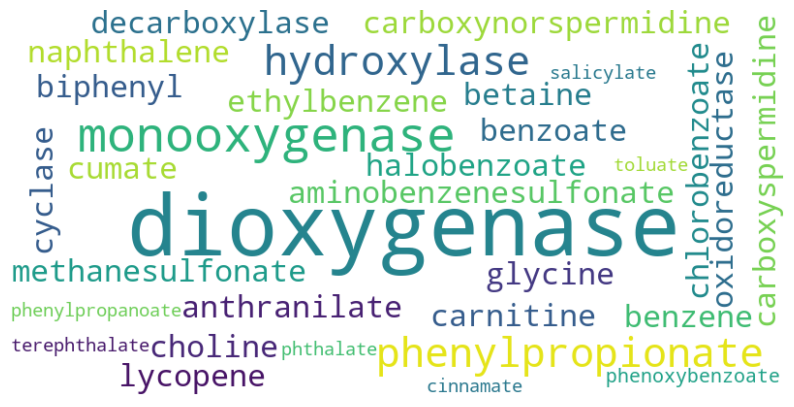

In [110]:
# Combine the text values into a single string
text = ' '.join(sorted(set([string for string in df_merged.Label.values.tolist() if len(string) > 0])))

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [155]:
# Remove duplicate rows
df_chars = df_merged[df_clean.columns].fillna('-')
df_label = pd.concat([df_chars, df_merged.Label], axis=1)
df_label

,150,177,178,179,180,181,182,185,186,187,...,997,1001,1005,1006,1007,1013,1014,1015,1053,Label
0,D,V,E,A,N,W,K,L,L,I,...,G,A,Q,E,N,L,S,A,G,lycopene cyclase
1,R,T,P,A,N,W,K,S,I,V,...,S,V,Q,K,G,L,K,S,R,carnitine monooxygenase
2,L,T,P,A,N,W,K,N,I,V,...,S,V,Q,K,G,L,K,S,R,carnitine monooxygenase
3,Q,G,Q,Y,N,W,K,T,L,A,...,A,A,Q,K,N,L,N,A,G,choline monooxygenase
4,A,T,P,A,N,W,K,I,I,V,...,S,V,Q,R,G,L,K,S,R,carnitine monooxygenase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,R,H,H,C,N,W,K,M,V,M,...,R,A,T,I,G,L,K,S,E,dioxygenase
1154,D,L,E,G,N,W,K,L,A,A,...,E,V,Q,A,V,S,H,G,G,phenylpropionate dioxygenase
1155,D,I,P,C,N,W,K,F,A,A,...,E,I,Q,K,V,L,R,G,P,biphenyl dioxygenase
1156,D,Y,E,C,N,W,K,I,A,A,...,Y,C,T,K,T,A,K,G,R,benzene dioxygenase


In [174]:
df_unique = df_label.drop_duplicates().fillna('-')
df_unique#[df_unique.isna().any(axis=1)]

,150,177,178,179,180,181,182,185,186,187,...,997,1001,1005,1006,1007,1013,1014,1015,1053,Label
0,D,V,E,A,N,W,K,L,L,I,...,G,A,Q,E,N,L,S,A,G,lycopene cyclase
1,R,T,P,A,N,W,K,S,I,V,...,S,V,Q,K,G,L,K,S,R,carnitine monooxygenase
2,L,T,P,A,N,W,K,N,I,V,...,S,V,Q,K,G,L,K,S,R,carnitine monooxygenase
3,Q,G,Q,Y,N,W,K,T,L,A,...,A,A,Q,K,N,L,N,A,G,choline monooxygenase
4,A,T,P,A,N,W,K,I,I,V,...,S,V,Q,R,G,L,K,S,R,carnitine monooxygenase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,R,H,H,C,N,W,K,M,V,M,...,R,A,T,I,G,L,K,S,E,dioxygenase
1154,D,L,E,G,N,W,K,L,A,A,...,E,V,Q,A,V,S,H,G,G,phenylpropionate dioxygenase
1155,D,I,P,C,N,W,K,F,A,A,...,E,I,Q,K,V,L,R,G,P,biphenyl dioxygenase
1156,D,Y,E,C,N,W,K,I,A,A,...,Y,C,T,K,T,A,K,G,R,benzene dioxygenase


In [160]:
df_unique.Label.value_counts(normalize=True)

Label
choline monooxygenase                                   0.410517
anthranilate dioxygenase                                0.129151
benzoate dioxygenase                                    0.068266
phenylpropionate dioxygenase                            0.059041
carnitine monooxygenase                                 0.047048
biphenyl dioxygenase                                    0.044280
                                                        0.040590
halobenzoate dioxygenase                                0.033210
dioxygenase                                             0.033210
salicylate hydroxylase                                  0.032288
naphthalene dioxygenase                                 0.032288
benzene dioxygenase                                     0.023063
terephthalate dioxygenase                               0.012915
methanesulfonate monooxygenase                          0.008303
aminobenzenesulfonate dioxygenase                       0.006458
chlorobenzoate diox

In [168]:
df_encoded = pd.get_dummies(df_unique.Label).astype(int)
df_encoded#[df_encoded.isna().any(axis=1)]

,,aminobenzenesulfonate dioxygenase,anthranilate dioxygenase,benzene dioxygenase,benzoate dioxygenase,biphenyl dioxygenase,carboxynorspermidine/carboxyspermidine decarboxylase,carnitine monooxygenase,chlorobenzoate dioxygenase,choline monooxygenase,...,naphthalene dioxygenase,oxidoreductase,phenoxybenzoate dioxygenase,phenylpropanoate dioxygenase,phenylpropionate dioxygenase,phenylpropionate/cinnamate dioxygenase,phthalate dioxygenase,salicylate hydroxylase,terephthalate dioxygenase,toluate dioxygenase
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1155,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1156,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
def target_mean(df, by, on):
    means = df.groupby(by)[on].mean()
    return df[by].map(means)

In [183]:
ftr_imp = []
X_collection = []
for i in df_encoded.columns:
    target = df_encoded[i].tolist()
    df_num = df_unique.drop('Label', axis=1).copy()
    df_num['Target'] = target
    for j in df_num.columns:
        df_num[j] = target_mean(df_num, by=j, on='Target')

    # Split the dataset into features (X) and target (y)
    X = df_num.drop('Target', axis=1)
    y = df_num['Target']

    X_collection.append(X)

    # Fit a random forest model to the data
    rf = RandomForestRegressor(random_state=0)
    rf.fit(X, y)
    ftr_imp.append(rf.feature_importances_)
arr = np.array(ftr_imp)
averages = np.mean(arr, axis=0)
X_avg = pd.concat(X_collection).groupby(level=0).mean()
averages

array([1.08021664e-02, 7.96062741e-03, 1.92378494e-02, 1.21236630e-02,
       1.58990920e-03, 2.60168938e-04, 4.71694750e-04, 3.67818043e-03,
       4.98598116e-03, 7.07338566e-03, 5.35966563e-03, 7.90698649e-04,
       6.86263696e-03, 7.60485020e-03, 1.20492089e-02, 2.06680619e-02,
       1.08131529e-03, 0.00000000e+00, 3.05949014e-03, 1.64946987e-02,
       9.87424501e-03, 9.01438816e-03, 0.00000000e+00, 2.73432483e-02,
       3.14621879e-03, 8.83340478e-03, 1.16802819e-02, 4.36551821e-03,
       7.64958428e-03, 1.84482295e-02, 6.72835920e-03, 1.24724291e-02,
       8.65301841e-03, 6.65981335e-03, 6.65736794e-03, 7.82496890e-03,
       8.64606204e-03, 9.87585508e-03, 6.97532452e-05, 8.91546150e-03,
       1.19159076e-02, 3.15272430e-03, 4.61343769e-03, 8.57672759e-03,
       4.07811233e-03, 1.13512779e-02, 1.63772099e-02, 1.27415601e-02,
       2.39349658e-02, 8.93862294e-03, 2.13843118e-02, 8.80754395e-03,
       5.57814093e-03, 8.14818814e-03, 4.65778040e-04, 1.32835784e-02,
      

In [184]:
# Get the feature importances and sort them in descending order
importances = pd.Series(averages, index=X.columns).sort_values(ascending=False)
importances

1001    0.039133
930     0.037479
1006    0.029566
992     0.027876
220     0.027343
          ...   
181     0.000260
682     0.000070
983     0.000000
217     0.000000
206     0.000000
Length: 105, dtype: float64

In [185]:
# Calculate the cumulative sum of the importance values
cumulative_importance = importances.cumsum()
cumulative_importance

1001    0.039133
930     0.076612
1006    0.106178
992     0.134054
220     0.161397
          ...   
181     0.999930
682     1.000000
983     1.000000
217     1.000000
206     1.000000
Length: 105, dtype: float64

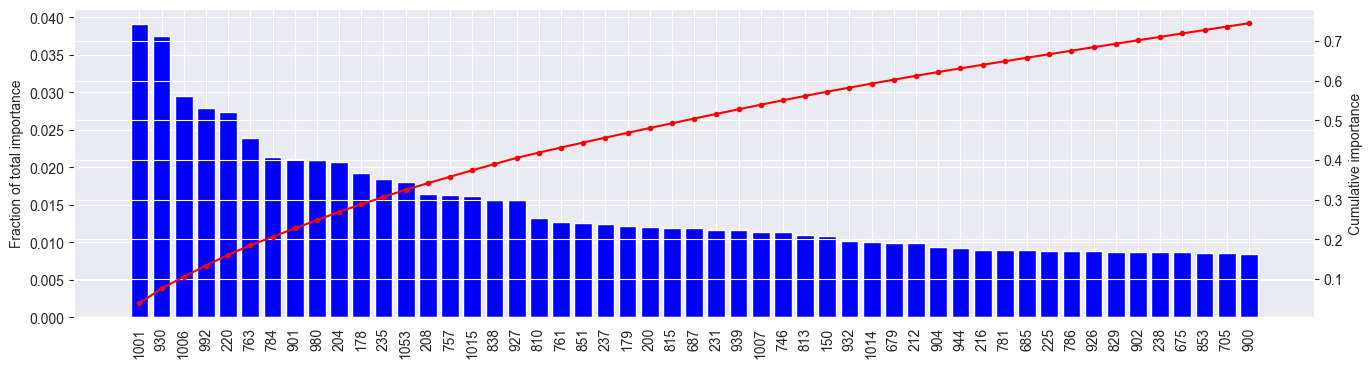

In [187]:
# Filter the feature importances to keep only those that contribute to 99% of the importance
most_important = importances[cumulative_importance <= 0.75].sort_values(ascending=False)
selected_features = importances[cumulative_importance <= 0.75].index
higher_importance = cumulative_importance[selected_features]

fig, ax1 = plt.subplots(figsize=(16, 4))

# Bar chart of percentage importance
xvalues = range(len(most_important))
ax1.bar(xvalues, most_important, color='b')
ax1.set_ylabel('Fraction of total importance')
ax1.tick_params(axis='y')

# Line chart of cumulative percentage importance
ax2 = ax1.twinx()
ax2.plot(xvalues, higher_importance, color='r', marker='.')
ax2.set_ylabel('Cumulative importance')
ax2.tick_params(axis='y')

# Rotate x-axis labels
plt.xticks(xvalues, most_important.index)

# Rotate x-axis labels
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

# Adjust layout to make sure labels are visible
# plt.tight_layout()

plt.show()

In [188]:
# Select only the columns corresponding to the selected features
X_selected = X_avg[selected_features]
X_selected

,1001,930,1006,992,220,763,784,901,980,204,...,225,786,926,829,902,238,675,853,705,900
0,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
1,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
2,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
3,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
4,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
1154,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
1155,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
1156,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714


In [189]:
# Select only the columns corresponding to the selected features
df_selected = df_unique[selected_features]
df_selected

,1001,930,1006,992,220,763,784,901,980,204,...,225,786,926,829,902,238,675,853,705,900
0,A,N,E,C,P,C,Q,D,L,C,...,I,R,F,E,E,P,F,D,T,T
1,V,E,K,V,P,T,I,-,R,C,...,F,Y,T,H,D,G,A,K,N,-
2,V,D,K,V,P,M,T,-,R,C,...,F,V,T,N,-,W,L,E,N,-
3,A,Y,K,C,P,Y,M,D,L,C,...,V,R,F,E,R,D,Y,D,T,S
4,V,E,R,V,P,T,I,-,R,C,...,F,Y,T,H,E,T,A,K,N,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,A,R,I,Y,E,T,R,Q,A,T,...,S,V,L,E,K,Q,Y,G,K,P
1154,V,A,A,W,A,T,R,P,E,W,...,A,V,R,W,E,P,V,S,L,P
1155,I,E,K,W,L,T,R,E,E,M,...,G,S,K,W,E,D,I,D,L,P
1156,C,M,K,W,D,T,R,D,E,I,...,A,V,K,F,D,A,I,S,L,P


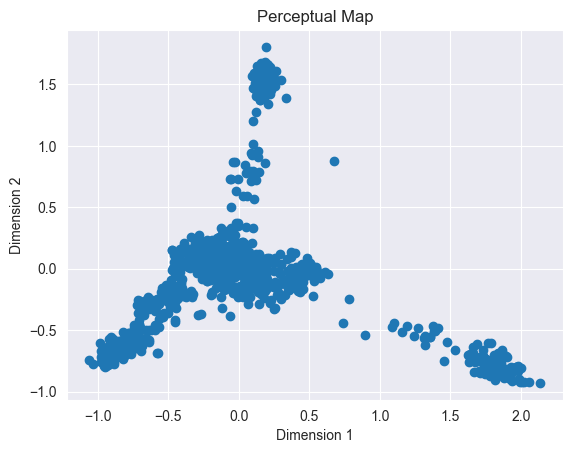

In [192]:
# Perform MCA
mca = MCA()
mca.fit(df_selected)

# Access the results
coordinates = mca.transform(df_selected)

# Plot the perceptual map
plt.scatter(coordinates[0], coordinates[1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Perceptual Map')
plt.show()

In [194]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.436,2.48%,2.48%
1,0.382,2.18%,4.66%


In [195]:
mca.row_coordinates(df_selected).head()

,0,1
0,-0.761668,-0.617561
1,-0.439748,0.067475
2,-0.391822,0.045947
3,-0.945145,-0.754986
4,-0.476741,0.152723


In [196]:
mca.column_coordinates(df_selected).head()

,0,1
1001_-,1.025244,1.419823
1001_A,-0.924613,-0.825047
1001_C,2.013643,-0.934854
1001_E,-0.222515,0.305835
1001_G,-0.297558,-0.344173


In [197]:
mca.column_coordinates(df_selected).shape

(946, 2)

In [198]:
mca.plot(
    df_selected,
    x_component=0,
    y_component=1
)

alt.Chart(...)

In [201]:
mca.row_cosine_similarities(df_selected).head()

,0,1
0,0.035857,0.023573
1,0.015386,0.000362
2,0.007948,0.000109
3,0.110985,0.070818
4,0.018954,0.001945


In [202]:
mca.column_cosine_similarities(df_selected).head()

,0,1
1001_-,0.000971,0.001861
1001_A,0.151303,0.120472
1001_C,0.425729,0.091761
1001_E,0.000092,0.000173
1001_G,0.000082,0.000109


In [203]:
mca.total_inertia_

17.549019607843007

In [204]:
mca.row_contributions_.cumsum(axis=0)

,0,1
0,0.001228,0.000922
1,0.001638,0.000933
2,0.001963,0.000938
3,0.003855,0.002315
4,0.004336,0.002371
...,...,...
1153,0.999887,0.999874
1154,0.999888,0.999874
1155,0.999894,0.999935
1156,0.999973,0.999941


In [205]:
mca.column_contributions_.cumsum(axis=0)

,0,1
1001_-,0.000044,0.000096
1001_A,0.005829,0.005352
1001_C,0.023170,0.009617
1001_E,0.023174,0.009626
1001_G,0.023178,0.009632
...,...,...
900_R,0.992186,0.995040
900_S,0.996406,0.997941
900_T,0.999979,0.999998
900_V,1.000000,1.000000


/var/folders/3s/lcw00jp9337f6sn4ym0dg10w0000gp/T/ipykernel_23954/3096386997.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter_cmap = cm.get_cmap('coolwarm')
/var/folders/3s/lcw00jp9337f6sn4ym0dg10w0000gp/T/ipykernel_23954/3096386997.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colorbar_cmap = cm.get_cmap('viridis')


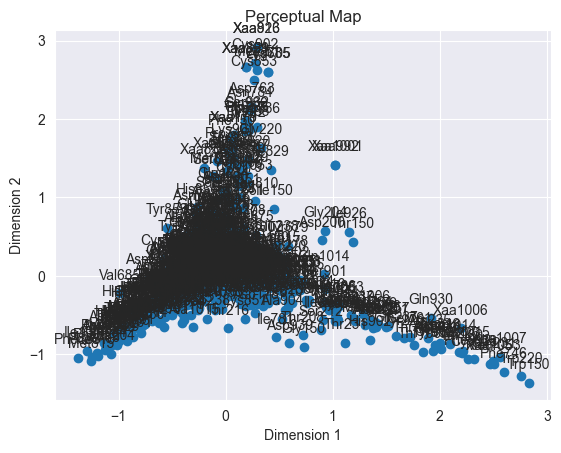

In [210]:
# Access the results
coordinates = mca.column_coordinates(df_selected)

# List of values ranging from 0 to 1 for coloring the scatter points
# color_values = [0.2, 0.8, 0.4, 0.6, 0.3, 0.9]

# Colormap for scatter plot
scatter_cmap = cm.get_cmap('coolwarm')

# Colormap for color bar
colorbar_cmap = cm.get_cmap('viridis')

# Plot the perceptual map as a scatter plot with colored points, labels, and color bar
fig, ax = plt.subplots()
scatter = ax.scatter(coordinates[0], coordinates[1])#, c=color_values, cmap=scatter_cmap)

# Add labels to each point
for row in coordinates.iterrows():
    # print(row[1][0], row[1][1])
    pos, aa = row[0].split('_')
    label = f"{seq3(aa)}{pos}"
    ax.annotate(label, (row[1][0], row[1][1]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Perceptual Map')
# plt.colorbar(scatter, label='Color Values', cmap=colorbar_cmap)
plt.show()